In [1]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

import math as mt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, fbeta_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix

import seaborn as sn
import pandas as pd

from ROOT import TFile, TTree, TChain

print("All classes initialized successfully!!!")

Welcome to JupyROOT 6.18/04
All classes initialized successfully!!!


In [2]:
sigChan3 = TChain("varTree")
sigChan3.Add("signal_SR3.root")
bkgChan3 = TChain("varTree")
bkgChan3.Add("background_SR3.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [3]:
sigChan3.Print()
bkgChan3.Print()

******************************************************************************
*Chain   :varTree   : signal_SR3.root                                        *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :    11619 : Total =          843713 bytes  File  Size =     714951 *
*        :          : Tree compression factor =   1.18                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :    11619 : Total  Size=      93670 bytes  File Size  =       6544 *
*Baskets :        3 : Basket Size=      32000 bytes  Compression=  14.24     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [4]:
sig3SampleSize = sigChan3.GetEntries()
bkg3SampleSize = bkgChan3.GetEntries()

sig3Full = sigChan3.AsMatrix()
bkg3Full = bkgChan3.AsMatrix()

In [5]:
# Load the input data scaler
scaler = joblib.load("../scaler.save")

# Load the model
loaded_model = m.load_model("../simplePer.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


2020-03-02 14:35:23.172527: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


In [6]:
sig3FullScaled = scaler.transform(sig3Full)
bkg3FullScaled = scaler.transform(bkg3Full)

sig3Predict = loaded_model.predict(sig3FullScaled)
bkg3Predict = loaded_model.predict(bkg3FullScaled)

print(sig3FullScaled.shape)
print(bkg3FullScaled.shape)
print(sig3Predict.shape)
print(bkg3Predict.shape)

(11619, 9)
(4108, 9)
(11619, 2)
(4108, 2)


In [12]:
# Weights for normalisation to Luminosity  

# N_bkg = 1937.09 # CR2                                                                                                                                                                                 
# N_bkg = 3646.28 # SR1                                                                                                                                                                                 
# N_bkg = 569.73 # SR2                                                                                                                                                                                  
N_bkg = 22.79 # SR3                                                                                                                                                                                     
# N_sig = 31.2*271/(5*pow(10,6)) # CR2                                                                                                                                                                  
# N_sig = 31.2*28976/(5*pow(10,6)) # SR1                                                                                                                                                                
# N_sig = 31.2*19077/(5*pow(10,6)) # SR2                                                                                                                                                                
N_sig = 31.2*11619/(5*pow(10,6)) # SR3  

w_sig = N_sig/sig3Predict.shape[0]
w_bkg = N_bkg/bkg3Predict.shape[0]
#w_sig=0.35
#w_bkg=1
print(N_sig,w_sig,N_bkg,w_bkg)

0.07250256 6.2399999999999995e-06 22.79 0.0055477117818889966


Discriminator plotted!!!
Weighted Discriminator plotted!!!


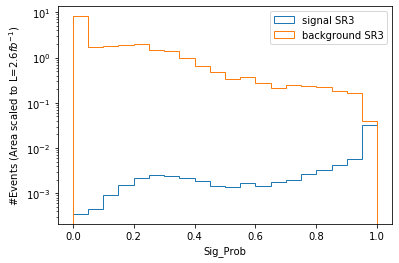

In [28]:
# Discriminator shape
plt.clf()
plt.yscale('log')
plt.hist(np.array(sig3Predict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='signal SR3')
plt.hist(np.array(bkg3Predict)[:,0], bins=20, range=(0,1), density=True, color=None, histtype='step', label='background SR3')
plt.xlabel("Sig_Prob")
plt.ylabel("#Events (Area scaled to 1)")
plt.legend()
plt.savefig("Discriminator_SR3.pdf")
print("Discriminator plotted!!!")

plt.clf()
plt.yscale('log')
plt.hist(np.array(sig3Predict)[:,0], 
         bins=20, 
         range=(0,1), 
         density=False, 
         weights=(N_sig/sig3Predict.shape[0])*np.ones(sig3Predict.shape[0]), 
         color=None, 
         histtype='step', 
         label='signal SR3')
plt.hist(np.array(bkg3Predict)[:,0], 
         bins=20, 
         range=(0,1), 
         density=False, 
         weights=(N_bkg/bkg3Predict.shape[0])*np.ones(bkg3Predict.shape[0]), 
         color=None, 
         histtype='step', 
         label='background SR3')
plt.xlabel("Sig_Prob")
plt.ylabel("#Events (Area scaled to L=$2.6fb^{-1}$)")
plt.legend()
plt.savefig("WeightedDiscriminator_SR3.pdf")
print("Weighted Discriminator plotted!!!")

In [22]:
# Significance Plot

sigProb = np.arange(0, 1, 0.001) 
sig3PredictSigProb = np.array(sig3Predict)[:,0]
bkg3PredictSigProb = np.array(bkg3Predict)[:,0]

SigWithCut = []

for x in sigProb: 
    sig3PredictClass = sig3PredictSigProb>x
    bkg3PredictClass = bkg3PredictSigProb>x
    nSig3TP = sig3PredictClass.sum()
    nSig3FP = bkg3PredictClass.sum()
    
    nSig3AfterCut = nSig3TP*w_sig
    nBkg3AfterCut = nSig3FP*w_bkg
    
    SigWithCut.append(nSig3AfterCut/mt.sqrt(nSig3AfterCut+nBkg3AfterCut))
    
    print(x, nSig3TP, nSig3FP, nSig3AfterCut, nBkg3AfterCut, nSig3AfterCut/mt.sqrt(nSig3AfterCut+nBkg3AfterCut))

0.0 11619 4106 0.07250256 22.77890457643622 0.015166901537051653
0.001 11616 3027 0.07248384 16.792923563777993 0.017649921362240542
0.002 11616 3002 0.07248384 16.654230769230768 0.01772294417511994
0.003 11615 2986 0.07247759999999999 16.565467380720545 0.017768630730876575
0.004 11615 2981 0.07247759999999999 16.5377288218111 0.017783461088705405
0.005 11615 2972 0.07247759999999999 16.4877994157741 0.017810249571331902
0.006 11615 2962 0.07247759999999999 16.432322297955206 0.017840157005132723
0.007 11612 2952 0.07245887999999999 16.376845180136318 0.017865610137640018
0.008 11611 2941 0.07245264 16.31582035053554 0.01789730420221532
0.009000000000000001 11610 2929 0.0724464 16.24924780915287 0.01793222547491259
0.01 11610 2918 0.0724464 16.18822297955209 0.01796584297822168
0.011 11610 2911 0.0724464 16.14938899707887 0.01798733463315591
0.012 11610 2905 0.0724464 16.116102726387535 0.01800581756911582
0.013000000000000001 11610 2901 0.0724464 16.09391187925998 0.0180181712271295

0.555 8827 344 0.055080479999999994 1.9084128529698148 0.03930818585438252
0.556 8823 341 0.05505552 1.891769717624148 0.03945821048055964
0.557 8819 338 0.05503056 1.8751265822784808 0.03961025134278729
0.558 8817 337 0.05501808 1.8695788704965919 0.03965843150453143
0.559 8812 336 0.054986879999999995 1.864031158714703 0.039693514149635525
0.56 8808 335 0.05496192 1.8584834469328138 0.03973322918409776
0.561 8804 335 0.05493695999999999 1.8584834469328138 0.03971544406469724
0.562 8798 335 0.05489951999999999 1.8584834469328138 0.039688765953756464
0.5630000000000001 8789 332 0.054843359999999994 1.841840311587147 0.039822323993640454
0.5640000000000001 8784 329 0.05481216 1.8251971762414798 0.03997577700045829
0.5650000000000001 8780 329 0.054787199999999994 1.8251971762414798 0.039957838346316804
0.5660000000000001 8773 328 0.05474352 1.8196494644595909 0.03998548738217997
0.5670000000000001 8771 326 0.054731039999999995 1.808554040895813 0.04009535355490072
0.5680000000000001 8762

0.9550000000000001 5109 7 0.03188016 0.03883398247322298 0.11988569153790857
0.9560000000000001 5092 6 0.031774079999999996 0.03328627069133398 0.12457037869541832
0.9570000000000001 5076 5 0.03167424 0.02773855890944498 0.1299469818332313
0.9580000000000001 5052 5 0.03152448 0.02773855890944498 0.1294958864107889
0.9590000000000001 5027 5 0.03136848 0.02773855890944498 0.1290250016833529
0.96 4994 5 0.03116256 0.02773855890944498 0.12840187193839464
0.961 4967 5 0.030994079999999997 0.02773855890944498 0.12789070823605786
0.962 4945 5 0.030856799999999997 0.02773855890944498 0.127473313903324
0.963 4918 5 0.030688319999999998 0.02773855890944498 0.12695995808089935
0.964 4890 5 0.0305136 0.02773855890944498 0.12642630232353985
0.965 4864 4 0.030351359999999997 0.022190847127555986 0.13241098000153456
0.966 4832 4 0.030151679999999997 0.022190847127555986 0.13179052010043854
0.967 4809 4 0.03000816 0.022190847127555986 0.13134339732689354
0.968 4784 4 0.02985216 0.022190847127555986 0.

In [20]:
print(np.where(SigWithCut==0.13656728475323998)[0])

[]


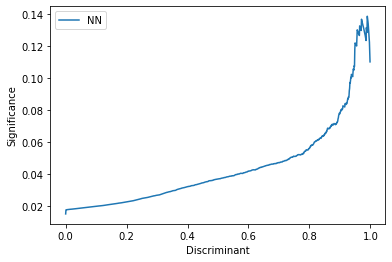

In [18]:
# Significance with Discriminant

plt.clf()
plt.plot(sigProb,SigWithCut, label="NN")
plt.xlabel("Discriminant")
plt.ylabel("Significance")
plt.legend()
plt.savefig("significance_SR3.pdf")

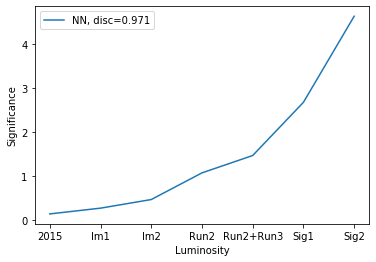

In [27]:
# Significance with Luminosity

disc = 0.971
lumisName = np.array([2015, "Im1", "Im2", "Run2", "Run2+Run3", "Sig1", "Sig2"])
lumis = np.array([2.6, 10, 30, 160, 300, 1000, 3000])
sigLumi = []
for lumi in lumis:
    
    sig3PredictClass = sig3PredictSigProb>disc
    bkg3PredictClass = bkg3PredictSigProb>disc
    nSig3TP = sig3PredictClass.sum()
    nSig3FP = bkg3PredictClass.sum()
    
    nSig3AfterCut = nSig3TP*w_sig*lumi/2.6
    nBkg3AfterCut = nSig3FP*w_bkg*lumi/2.6

    sigLumi.append(nSig3AfterCut/mt.sqrt(nSig3AfterCut+nBkg3AfterCut))
    
plt.clf()
plt.plot(lumisName,sigLumi, label="NN, disc=0.971")
plt.xlabel("Luminosity")
plt.ylabel("Significance")
plt.legend()
plt.savefig("significance_Lumi_SR3.pdf")